<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7. Particle Filtering

This notebook replicates the figures of Chapter 7 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

To avoid clutter, the following refactorings have been performed:
* All the plotting functions are stored in `plotting.py`.
* After its initial demonstration, any redundant data simulation is stored in `simulations.py`.
* Any miscellaneous simple utility function that is reused is stored in `utils.py`.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



##7.0 Imports and Pendulum Simulation

In [1]:
!git clone https://github.com/petergchang/sarkka-jax.git
%cd sarkka-jax
!pip install -e .

Cloning into 'sarkka-jax'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 404 (delta 169), reused 172 (delta 93), pack-reused 113
Receiving objects: 100% (404/404), 1.95 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (214/214), done.
/content/sarkka-jax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/sarkka-jax
     |████████████████████████████████| 72 kB 195 kB/s 
  Running setup.py develop for ssm-jax


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax

import simulations as sim
import plotting as plot
import utils as utils

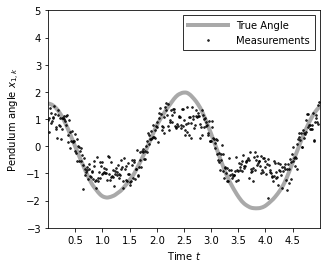

In [3]:
dt = 0.0125
params = sim.pendulum_default_params(dt=dt)
time_grid, (states, obs) = sim.simulate_pendulum_with_default_params(dt=dt)

# Plot the generated data
plot.plot_pendulum(time_grid, states[:,0], obs)

##7.4 Sequential Importance Resampling

In [ ]:
from jax.scipy.stats import multivariate_normal

# Bootstrap Particle Filter (Algorithm 7.5)
def bootstrap_pf(key, m_0, P_0, f, h, Q, R, Y, n_particles):
    def _step(carry, rng_t):
        key, t = rng_t
        weights, particles = carry
        key, subkey = jr.split(key, 2)

        # 1. Draw new points from (Gaussian) dynamic model
        m_pred = jax.vmap(f, 0, 0)(particles)
        keys_pred = jr.split(key, n_particles)
        normal_sample_vec = jax.vmap(jr.multivariate_normal, (0, 0, None), 0)
        particles_pred = normal_sample_vec(keys_pred, m_pred, Q)

        # 2. Calculate the weights from (Gaussian) measurement model
        obs_pred = jax.vmap(h, 0, 0)(particles_pred)
        normal_pdf_vec = jax.vmap(multivariate_normal.pdf, (None, 0, None), 0)
        weights_post = normalize(normal_pdf_vec(Y[t], obs_pred, R), -1)

        # 3. Perform resampling
        weights_post, particles_post = resample(subkey, weights_post, particles_pred)
        
        return (weights_post, particles_post), (weights_post, particles_post)

    def resample(key, weights, particles):
        idx = jr.categorical(key, jnp.log(weights), shape=(n_particles,))
        weights_post = jnp.ones(n_particles) / n_particles
        return weights_post, particles[idx]
    
    def normalize(weights, axis):
        return weights / jnp.sum(weights, axis=axis, keepdims=True)

    num_timesteps = len(Y)
    
    # Prior (Gaussian) particles and (uniform) weights
    key, subkey = jr.split(key, 2)
    particles = jr.multivariate_normal(key, m_0, P_0, shape=(n_particles,1))
    weights = jnp.ones(n_particles)/n_particles

    rngs = jr.split(subkey, num_timesteps)
    carry = (weights, particles)
    _, (ws, ps) = lax.scan(
        _step, carry, (rngs, jnp.arange(num_timesteps))
    )
    return ws, ps

In [ ]:
key, subkey = jr.split(key, 2)
P_0 = jnp.eye(m_0.shape[-1])*0.1
n_particles = 2000
_, particles_pf = bootstrap_pf(key, m_0, P_0, f, h, Q, r, obs, n_particles)
m_pf = jnp.mean(particles_pf, axis=1)

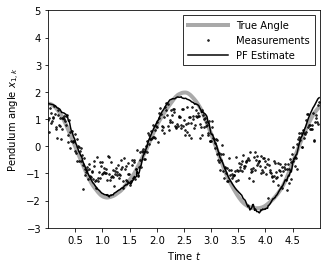

In [ ]:
# Plot the generated data (Replicates Figure 7.3)
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_pf[:,0,0], color='k', linewidth=1.5, label="PF Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

We compute the RMSE of the PF estimate.

In [ ]:
# Helper function to compute RMSE
def compute_rmse(y, y_est):
    num_samples = y.shape[0]
    return jnp.sqrt(jnp.sum((y-y_est)**2)/num_samples)

# Compute RMSE of the PF estimate
rmse_pf = compute_rmse(states[:,0,0], m_pf[:,0,0])

print(f'The RMSE of the PF estimate of the angle is: {rmse_pf:.2f},')
print(f'The standard deviation of measurement noise is: {jnp.sqrt(r):.2f}')

The RMSE of the PF estimate of the angle is: 0.14,
The standard deviation of measurement noise is: 0.55


Next, to replicate Figure 7.4, we generate clutter (outlier) pendulum measurements.

We generate such clutter by generating a random number in the range [-2, 2] with probability 50% at each time step.

In [ ]:
# Function to simulate pendulum
def simulate_pendulum_clutter(key, h, r, states, c_range, c_prob):
    def clutter(state, rng):
        key1, key2, key3 = jr.split(rng, 3)
        # Uncluttered observation
        obs_u = h(state) + jr.normal(key1) * r
        # # Cluttered observation
        obs_c = jnp.array([jr.uniform(key2, minval=-c_range, maxval=c_range)])
        # Clutter with probability c_prob
        obs = jr.choice(key3, jnp.array([obs_u, obs_c]), 
                        p=jnp.array([c_prob, 1-c_prob]))
        return obs

    steps = states.shape[0]
    rngs = jr.split(key, steps)
    clutter_vec = jax.vmap(clutter, (0, 0), 0)
    return clutter_vec(states, rngs)

In [ ]:
key, subkey = jr.split(jr.PRNGKey(0), 2)

# Simulate cluttered pendulum angle
obs_c = simulate_pendulum_clutter(key, h, r, states, 2, 0.5)

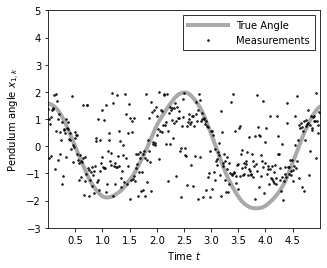

In [ ]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs_c, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we implement a version of particle filter that incorporates the indicator variable for whether the observation for a timestep is clutter or not as part of its state.

In [ ]:
from jax.scipy.stats import multivariate_normal

# Bootstrap Particle Filter for Cluttered Dataset
def bootstrap_pf_c(key, m_0, P_0, f, h, Q, R, Y, n_particles, c_prob):
    def _step(carry, rng_t):
        key, t = rng_t
        weights, particles = carry
        key, subkey = jr.split(key, 2)

        # 1. Draw new points from (Gaussian) dynamic model
        m_pred = jax.vmap(f, 0, 0)(particles)
        keys_pred = jr.split(key, n_particles)
        normal_sample_vec = jax.vmap(jr.multivariate_normal, (0, 0, None), 0)
        particles_pred = normal_sample_vec(keys_pred, m_pred, Q)

        # 2. Calculate the weights from (Gaussian) measurement model
        key, subkey = jr.split(subkey, 2)
        obs_pred = jax.vmap(h, 0, 0)(particles_pred)
        normal_pdf_vec = jax.vmap(multivariate_normal.pdf, (None, 0, None), 0)
        w_unc = normal_pdf_vec(Y[t], obs_pred, R)
        c_idx = jr.uniform(key, shape=(n_particles,))
        weights_post = normalize(jnp.where(c_idx < c_prob, w_unc, 0.25), -1)

        # 3. Perform resampling
        key, _ = jr.split(subkey, 2)
        weights_post, particles_post = resample(key, weights_post, particles_pred)
        
        return (weights_post, particles_post), (weights_post, particles_post)

    def resample(key, weights, particles):
        idx = jr.categorical(key, jnp.log(weights), shape=(n_particles,))
        weights_post = jnp.ones(n_particles) / n_particles
        return weights_post, particles[idx]
    
    def normalize(weights, axis):
        return weights / jnp.sum(weights, axis=axis, keepdims=True)

    num_timesteps = len(Y)
    
    # Prior (Gaussian) particles and (uniform) weights
    key, subkey = jr.split(key, 2)
    particles = jr.multivariate_normal(key, m_0, P_0, shape=(n_particles,1))
    weights = jnp.ones(n_particles)/n_particles

    rngs = jr.split(subkey, num_timesteps)
    carry = (weights, particles)
    _, (ws, ps) = lax.scan(
        _step, carry, (rngs, jnp.arange(num_timesteps))
    )
    return ws, ps

Finally, we borrow the GHKF implementation from Ch.6 for comparison with the particle filter.

In [ ]:
from numpy.polynomial.hermite_e import hermegauss
from sklearn.utils.extmath import cartesian

# Additive GHKF (Algorithm 6.7)
def ghkf_additive(m_0, P_0, f, h, Q, R, p, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step:
        # 1. Form sigma points
        sigmas_pred = compute_sigmas(m_k, P_k, sigmas)
        # 2. Propagate the sigma points
        sigmas_pred = jax.vmap(f, 0, 0)(sigmas_pred)
        # 3. Compute predicted mean and covariance
        m_pred = jnp.tensordot(weights, sigmas_pred, axes=1)
        outer = lambda x, y: jnp.atleast_2d(x).T @ jnp.atleast_2d(y)
        outer = jax.vmap(outer, 0, 0)
        P_pred = jnp.tensordot(weights, 
                               outer(sigmas_pred-m_pred, sigmas_pred-m_pred), 
                               axes=1) + Q

        # Update step:
        # 1. Form sigma points
        sigmas_update = compute_sigmas(m_pred, P_pred, sigmas)
        # 2. Propagate the sigma points
        sigmas_update_prop = jax.vmap(h, 0, 0)(sigmas_update)
        # 3. Compute params
        mu = jnp.tensordot(weights, sigmas_update_prop, axes=1)
        S = jnp.tensordot(weights, 
                          outer(sigmas_update_prop-mu, sigmas_update_prop-mu), 
                          axes=1) + R
        C = jnp.tensordot(weights, 
                          outer(sigmas_update-m_pred, sigmas_update_prop-mu), 
                          axes=1)

        # 4. Compute posterior
        K = C @ jnp.linalg.inv(S)
        m_post = m_pred + K @ (Y[t] - mu)
        P_post = P_pred - K @ S @ K.T
        
        return (m_post, P_post), (m_post, P_post)

    # Helper functions
    def compute_sigmas(m, P, sigmas):
        # Slightly convoluted way in order to preserve desired dimensions
        disc = jax.vmap(jnp.matmul, [None,0], 0)(jnp.linalg.cholesky(P), sigmas)
        return jax.vmap(jnp.add, [None,0], 0)(m, disc)

    # Compute sigmas and weights
    n = P_0.shape[0]
    num_timesteps = len(Y)
    samples_1d, weights_1d = hermegauss(p)
    weights_1d /= weights_1d.sum()
    sigmas = cartesian(jnp.array([samples_1d] * n))
    weights = jnp.prod(cartesian(jnp.array([weights_1d] * n)), axis=1)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [ ]:
# Params for GHKF
p = 10

# Compute GHKF estimates with true R
m_ghkf, P_ghkf = ghkf_additive(m_0, P_0, f, h, Q, r, p, obs_c)

# Compute GHKF estimates with increased R
m_ghkf_r, P_ghkf_r = ghkf_additive(m_0, P_0, f, h, Q, r*20, p, obs_c)

# Compute PF estimates
key, subkey = jr.split(subkey, 2)
n_particles = 2000
_, particles_pf_c = bootstrap_pf_c(key, m_0, P_0, f, h, Q, r, obs_c, n_particles, 0.5)
m_pf_c = jnp.mean(particles_pf_c, axis=1)

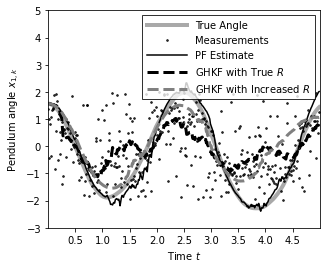

In [ ]:
# Plot the generated data (Replicates Figure 7.4)
plt.figure()
plt.plot(time_grid, states[:,0,0], color='darkgray', linewidth=4, label="True Angle")
plt.plot(time_grid, obs_c, 'ok', fillstyle='none', ms=1.5, label='Measurements')
plt.plot(time_grid, m_pf_c[:,0,0], color='k', linewidth=1.5, label="PF Estimate")
plt.plot(time_grid, m_ghkf[:,0,0], 'k--', linewidth=3, label="GHKF with True $R$")
plt.plot(time_grid, m_ghkf_r[:,0,0], '--', color='gray', linewidth=3, label="GHKF with Increased $R$")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.xticks(jnp.arange(0.5, 4.6, 0.5))
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

In [ ]:
# Compute RMSE of the GHKF estimate with true R
rmse_ghkf = compute_rmse(states[:,0,0], m_ghkf[:,0,0])
# Compute RMSE of the GHKF estimate with increased R
rmse_ghkf_r = compute_rmse(states[:,0,0], m_ghkf_r[:,0,0])
# Compute RMSE of the PF estimate
rmse_pf_c = compute_rmse(states[:,0,0], m_pf_c[:,0,0])

print(f'The RMSE of the GHKF estimate with true R is: {rmse_ghkf:.2f},')
print(f'The RMSE of the GHKF estimate with increased R is: {rmse_ghkf_r:.2f},')
print(f'The RMSE of the PF estimate of the angle is: {rmse_pf_c:.2f},')

The RMSE of the GHKF estimate with true R is: 1.03,
The RMSE of the GHKF estimate with increased R is: 0.74,
The RMSE of the PF estimate of the angle is: 0.26,
